# COVID-19 dataset

In this analysis, we examine COVID-19 data. The code provided generates the following tables, which are used for the plots:

- `covid_contingency.csv`
- `covid_expression.csv`
- `covid_topic.csv`

The file containing the model was removed due to its large size, and the contents of the `factm_input` folder were deleted as we do not have permission to repost the data.

## Packages & functions

In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
import dill
import sys

import matplotlib.pyplot as plt
import seaborn as sns
import os.path

import pickle

from copy import deepcopy
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, fowlkes_mallows_score
from sklearn.preprocessing import scale

from scipy.optimize import linear_sum_assignment

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap.umap_ as umap

In [ ]:
# we use older version of the model 
# - nothing important changes between this version and the version in 'factm' folder
sys.path.append('factm_old_version')
from model_class_k import *

In [2]:
def assignment_problem(cost_matrix):
    clusters_order = linear_sum_assignment(cost_matrix)[1]
    return clusters_order

In [ ]:
def eval_model(model_params, data_info_name='RPRA_CT12', L=19, ctm_view_number=3):
    model_path = 'models/'+model_params+'_L'+str(L)+'.pkl'
    
    with open(model_path, "rb") as input_file:
        factm = pickle.load(input_file)
    with open('factm_input/'+str(data_info_name)+'_info.pkl', "rb") as input_file:
        info = pickle.load(input_file)

    clusters = np.concatenate(factm.get_pe_clusters(ctm_view_number))
    cell_type_groups = np.concatenate([np.array(info[i]['cell_type_groups']) for i in range(len(info))])

    res = {}

    res['ARI_cell_type_groups'] = [deepcopy(adjusted_rand_score(cell_type_groups, clusters))]
    res['AMI_cell_type_groups'] = [deepcopy(adjusted_mutual_info_score(cell_type_groups, clusters))]
    res['FM_cell_type_groups'] = [deepcopy(fowlkes_mallows_score(cell_type_groups, clusters))]
    res['elbo'] = [deepcopy(factm.elbo_sequence[-1])]
    res['K'] = [deepcopy(factm.fa.K)]

    return res

In [ ]:
def get_model_params(model_params, L, ctm_view_number=3, data_info_name='RPRA_CT12'):

    with open('models/'+model_params+'_L'+str(L)+'.pkl', "rb") as input_file:
        factm = dill.load(input_file)
    with open('factm_input/'+str(data_info_name)+'_info.pkl', "rb") as input_file:
        info = dill.load(input_file)
    with open('factm_input/gene_names.pkl', "rb") as input_file:
        gene_names = dill.load(input_file)
    with open('factm_input/feature_names.pkl', "rb") as input_file:
        feature_names = dill.load(input_file)
    with open('factm_input/'+str(data_info_name)+'_Study_ID.pkl', 'rb') as input_file:
        study_id = dill.load(input_file)
    meta = pd.read_csv('factm_input/meta.csv', index_col=0)
    
    meta = meta.loc[study_id,:]
        
    clusters = np.concatenate(factm.get_pe_clusters(ctm_view_number))
    classes_all = [np.concatenate([np.array(info[i]['cell_type_spectra']) for i in range(len(info))]),
                   np.concatenate([np.array(info[i]['cell_type_groups']) for i in range(len(info))]),
                   np.concatenate([np.array(info[i]['cell_type']) for i in range(len(info))])]
    if L == 10:
        classes = np.concatenate([np.array(info[i]['cell_type_spectra']) for i in range(len(info))])
    if L == 19:
        classes = np.concatenate([np.array(info[i]['cell_type_groups']) for i in range(len(info))])
    if L == 32:
        classes = np.concatenate([np.array(info[i]['cell_type']) for i in range(len(info))])
    
    return factm, info, gene_names, feature_names, classes, clusters, meta, classes_all

In [ ]:
def compare_clustering(classes, clusters, norm='rows'):
    df = pd.crosstab(classes, clusters)
    if norm == 'rows':
        num_cell_types = np.sum(df, axis=1)
        df_norm = (df.T/num_cell_types).T
        best_order = assignment_problem(-df_norm)
    if norm == 'cols':
        num_cell_types = np.sum(df, axis=0)
        df_norm = (df/num_cell_types)
        best_order = assignment_problem(-df_norm)
    if norm == 'chisq':
        expected = (1/np.sum(np.array(df)))*np.outer(np.sum(df, axis=1), np.sum(df, axis=0))
        df_norm = (df)**2/expected
        best_order = assignment_problem(-df_norm)

    ari = adjusted_mutual_info_score(classes, clusters)
    ax = sns.heatmap(df_norm.loc[:, best_order], xticklabels=True, yticklabels=True, vmax=1)
    ax.set_title('AMI = '+str(np.round(ari,2)))
    ax.set_xlabel('Topics')
    ax.set_ylabel('')
    plt.show()

def compare_clustering_table(classes, clusters, norm='rows'):
    df = pd.crosstab(classes, clusters)
    if norm == 'rows':
        num_cell_types = np.sum(df, axis=1)
        df_norm = (df.T/num_cell_types).T
        best_order = assignment_problem(-df_norm)
    if norm == 'cols':
        num_cell_types = np.sum(df, axis=0)
        df_norm = (df/num_cell_types)
        best_order = assignment_problem(-df_norm)
    if norm == 'chisq':
        expected = (1/np.sum(np.array(df)))*np.outer(np.sum(df, axis=1), np.sum(df, axis=0))
        df_norm = (df)**2/expected
        best_order = assignment_problem(-df_norm)
        
        
    return df_norm.loc[:, best_order]
    
    

In [187]:
def compare_topics(true_topics, topics, classes, clusters, norm='rows'):
    df = pd.crosstab(classes, clusters)
    if norm == 'rows':
        num_cell_types = np.sum(df, axis=1)
        df_norm = (df.T/num_cell_types).T
        best_order = assignment_problem(-df_norm)
    if norm == 'cols':
        num_cell_types = np.sum(df, axis=0)
        df_norm = (df/num_cell_types)
        best_order = assignment_problem(-df_norm)
    
    res = sns.clustermap(true_topics, 
              center=0, cmap="bwr",  yticklabels=true_topics.index, xticklabels=true_topics.columns,
              col_cluster=False)
    
    new_order = true_topics.index[res.dendrogram_row.reordered_ind]
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,6))
    sns.heatmap(true_topics.loc[new_order,:], center=0, cmap="bwr",  yticklabels=[], ax=ax1, xticklabels=true_topics.columns,
                vmin=-4, vmax=4)
    ax1.set(xlabel=' ', ylabel='Genes')
    ax1.set_title('Averaged gene expression')
    
    xaxlab = ["Topic" + str(best_order[i]) for i in range(best_order.shape[0])]
    sns.heatmap(topics.loc[new_order,best_order], center=0, cmap="bwr",  yticklabels=[], 
               xticklabels = xaxlab, ax=ax2, vmin=-4, vmax=4)
    ax2.set(xlabel=' ', ylabel='Genes')
    ax2.set_title('Estimated topics')
    plt.show()

def compare_topics_table(true_topics, topics, classes, clusters, norm='rows'):
    df = pd.crosstab(classes, clusters)
    if norm == 'rows':
        num_cell_types = np.sum(df, axis=1)
        df_norm = (df.T/num_cell_types).T
        best_order = assignment_problem(-df_norm)
    if norm == 'cols':
        num_cell_types = np.sum(df, axis=0)
        df_norm = (df/num_cell_types)
        best_order = assignment_problem(-df_norm)
    
    
    res = sns.clustermap(true_topics, 
              center=0, cmap="bwr",  yticklabels=true_topics.index, xticklabels=true_topics.columns,
              col_cluster=False)
    
    new_order = true_topics.index[res.dendrogram_row.reordered_ind]

    df1 = pd.DataFrame(true_topics.loc[new_order,:])
    df1.columns = true_topics.columns
    
    df2 = pd.DataFrame(topics.loc[new_order,best_order])
    df2.columns = best_order
   
    return df1, df2

## COVID-19 analysis

In [ ]:
model_params = 'RPRA_CT12_viewsFCT12'
L = 19

In [ ]:
# Data used for training:
# (Note: The files in the `factm_input` folder have been removed as we do not have permission to repost the data.)
with open('factm_input/'+'RPRA_CT12'+'.pkl', "rb") as input_file:
    factm_input = dill.load(input_file)

### Clustering performance metrix

In [164]:
# We compute basic metrics to get the performance of the clustering: 
# - Adjusted Rand Index
# - Adjusted Mutual Information
# - Fowlkes-Mallows Index

eval_model(model_params)

{'ARI_cell_type_groups': [0.31702758450836005],
 'AMI_cell_type_groups': [0.5226447176000913],
 'FM_cell_type_groups': [0.4426062776891369],
 'elbo': [-451072193.57174605],
 'K': [5]}

In [ ]:
# loads model and all the information needed
# including true cell types (classes), inferred topics (clusters), the whole model (factm) etc.
factm, info, gene_names, feature_names, classes, clusters, meta, _ = get_model_params(model_params, L)

### Cell types-topics matching

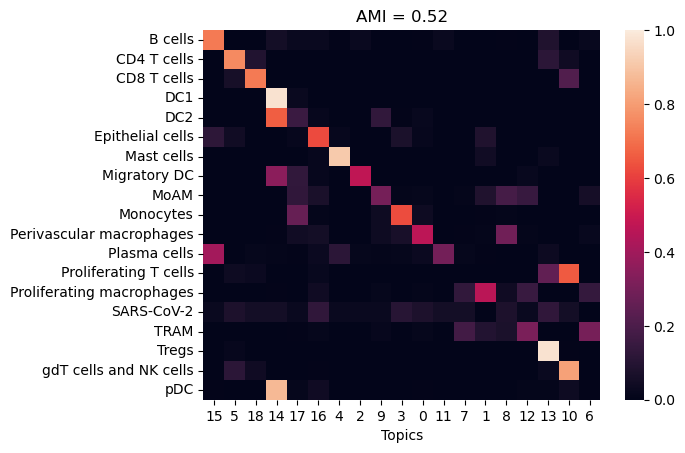

In [ ]:
# plot comparind inferred clusters with true classes
compare_clustering(classes, clusters, 'rows')

In [ ]:
# the same as above saved in csv -> plot in R
# cont_tab = compare_clustering_table(classes, clusters)
# cont_tab.to_csv('.csv')

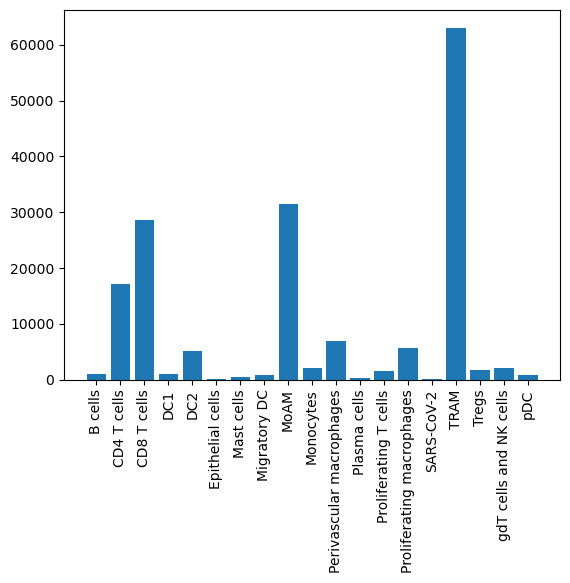

In [171]:
# Cell types' abundances
plt.bar(height=np.unique(classes, return_counts=True)[1], x=np.unique(classes, return_counts=True)[0])
plt.xticks(rotation=90)
plt.show()

### Comparing distributions over genes

In [ ]:
gene_expression = pd.read_csv('factm_input/gene_expression_z_score.csv', index_col=0)

In [184]:
topics = factm.get_pe_topics(3)
topics = scale(topics, axis=0).T
topics = pd.DataFrame(topics)
topics.index = gene_names

d:\anaconda3\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


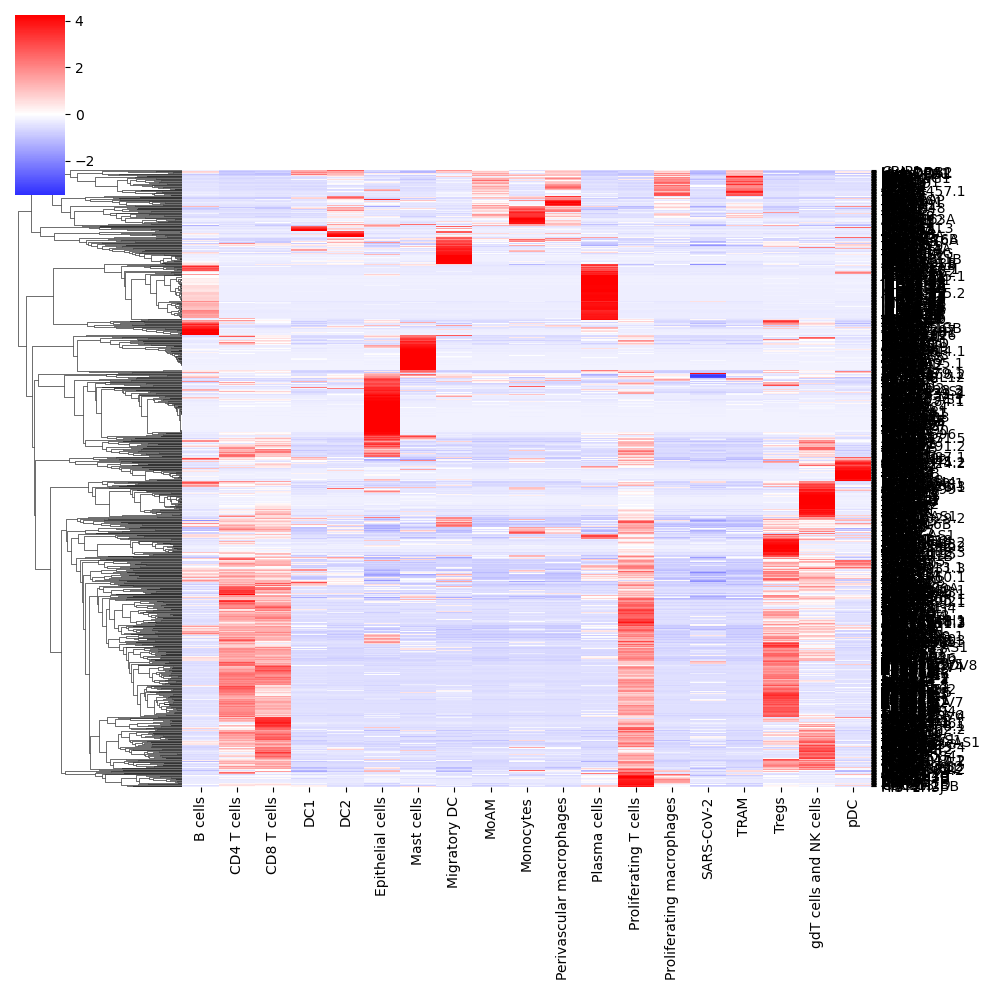

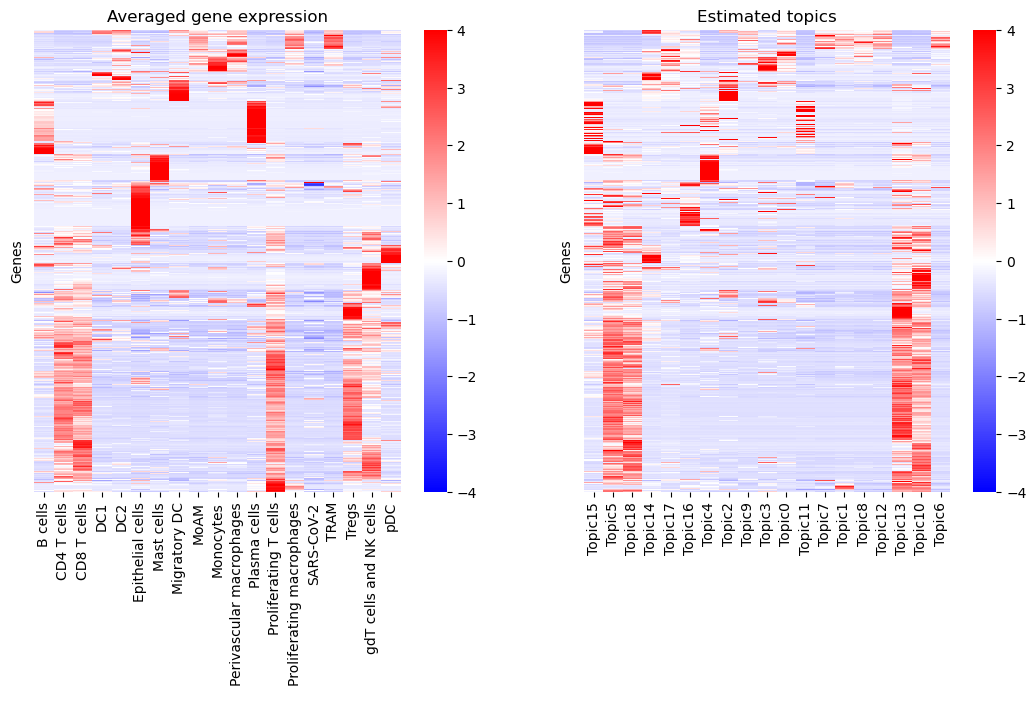

In [185]:
compare_topics(gene_expression, topics, classes, clusters)

d:\anaconda3\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


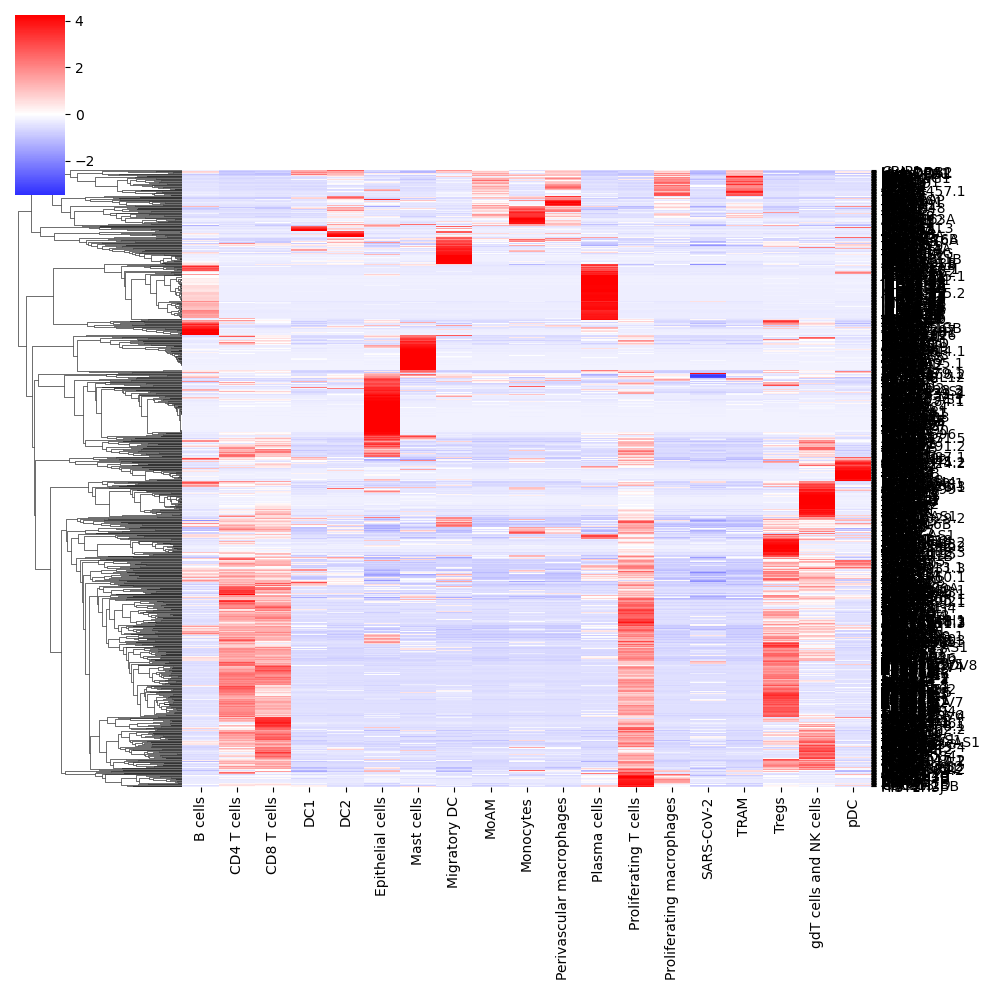

In [188]:
df1, df2 = compare_topics_table(gene_expression, topics, classes, clusters)

In [ ]:
# df1.to_csv('covid_expression.csv')
# df2.to_csv('covid_topic.csv')

### Umap plots of single cells

In [18]:
scaler_mod = StandardScaler(with_std=False)
pca_mod = PCA(100) 
umap_mod = umap.UMAP(random_state=123)

In [19]:
cell_genes_scaled = scaler_mod.fit_transform((cell_genes))

In [20]:
cell_genes_pca = pca_mod.fit_transform(cell_genes_scaled)

In [22]:
embedding_umap = umap_mod.fit_transform(cell_genes_pca)

d:\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [189]:
classes_map = {
    "B cells": 'B', 
    "CD4 T cells": 'CD4 T', 
    "CD8 T cells": 'CD8 T', 
    "DC1": "DC1",                     
    "DC2": 'DC2', 
    "Epithelial cells": 'Epithelial', 
    "Mast cells": 'Mast', 
    "Migratory DC": "Migratory DC",  
    "MoAM": "MoAM", 
    "Monocytes": "Monocytes",                 
    "Perivascular macrophages": "PVM", 
    "Plasma cells": 'Plasma', 
    "Proliferating T cells": 'Prol. T',    
    "Proliferating macrophages": "Prol. macs.",
    "SARS-CoV-2": "SARS-CoV-2",
    "TRAM": "TRAM",
    "Tregs": 'Tregs', 
    "gdT cells and NK cells": "gdT and NK",
    "pDC": "pDC"
}

In [190]:
class_order = ['B cells', 'Plasma cells', 
               'CD4 T cells', 'CD8 T cells', 'Proliferating T cells', 'Tregs', 'gdT cells and NK cells',
               'Monocytes',
               'TRAM', 'MoAM','Perivascular macrophages', 'Proliferating macrophages',
               'DC1', 'DC2', 'Migratory DC', 'pDC',
               'Epithelial cells', 'Mast cells',   'SARS-CoV-2']

class_order_new_names = ['B', 'Plasma', 'CD4 T', 'CD8 T', 'Prol. T', 'Tregs', 'gdT and NK', 'Monocytes', 'TRAM', 'MoAM', 'PVM', 'Prol. macs.', 'DC1', 'DC2', 'Migratory DC', 'pDC', 'Epithelial', 'Mast', 'SARS-CoV-2']
classes_order_names = np.searchsorted(np.unique(classes), class_order)

In [191]:
def map_cell_type(cell):
    return classes_map.get(cell, cell) 
vectorized_map = np.vectorize(map_cell_type)
classes_new_names = vectorized_map(classes)

In [192]:
cell_type_palette = {
    "B cells": "#ADD8E6",  # Light Blue
    "Plasma cells": "#00008B",  # Dark Blue
    "CD4 T cells": "#32CD32",  # Green
    "CD8 T cells": "#228B22",  # Bright Green
    "Proliferating T cells": "#9ACD32",  # Yellow Green
    "Tregs": "#98FB98",  # Mint Green
    "gdT cells and NK cells": "#808000",  # Olive Green
    "Monocytes": "#D2B48C",  # Light Brown
    "TRAM": "#DAA520",  # Goldenrod
    "MoAM": "#FFA500",  # Orange
    "Perivascular macrophages": "#B22222",  # Rust Red
    "Proliferating macrophages": "#8B0000",  # Dark Red
    "DC1": "#008080",  # Teal
    "DC2": "#00FFFF",  # Cyan
    "Migratory DC": "#87CEEB",  # Sky Blue
    "pDC": "#E6E6FA",  # Lavender
    "Epithelial cells": "#FFC0CB",  # Pink
    "Mast cells": "#800080",  # Purple
    "SARS-CoV-2": "#696969"  # Dark Gray
}
cell_type_palette_new_names = {classes_map.get(key, key): value for key, value in cell_type_palette.items()}

topic_palette = {
    "Topic 16": "#ADD8E6",  # Light Blue
    "Topic 12": "#00008B",  # Dark Blue
    "Topic 6": "#32CD32",  # Green
    "Topic 19": "#228B22",  # Bright Green
    "Topic 8": "#9ACD32",  # Yellow Green
    "Topic 14": "#98FB98",  # Mint Green
    "Topic 11": "#808000",  # Olive Green
    "Topic 4": "#D2B48C",  # Light Brown
    "Topic 13": "#DAA520",  # Goldenrod
    "Topic 10": "#FFA500",  # Orange
    "Topic 1": "#B22222",  # Rust Red
    "Topic 2": "#8B0000",  # Dark Red
    "Topic 15": "#008080",  # Teal
    "Topic 18": "#00FFFF",  # Cyan
    "Topic 3": "#87CEEB",  # Sky Blue
    "Topic 7": "#E6E6FA",  # Lavender
    "Topic 17": "#FFC0CB",  # Pink
    "Topic 5": "#800080",  # Purple
    "Topic 9": "#696969"  # Dark Gray
}

In [193]:
clusters = ['Topic '+ (1+cell_types_factm[i]).astype('str') for i in range(len(cell_types_factm))]
clusters_order = ['Topic '+ (1+best_order[classes_order_names[i]]).astype('str') for i in range(len(best_order))]

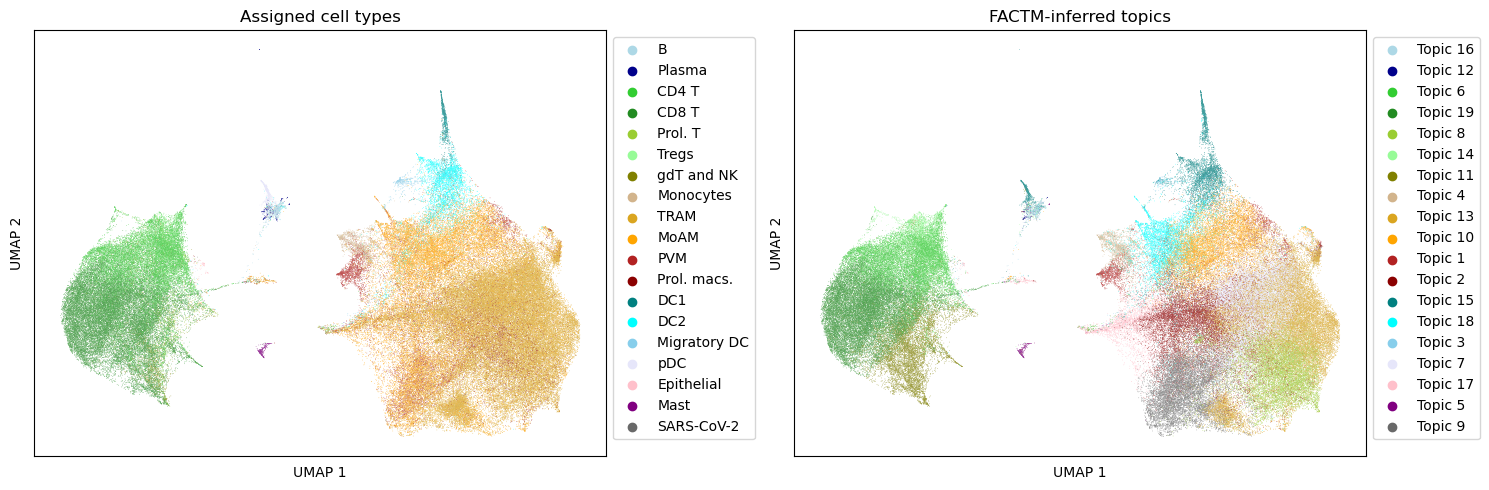

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.scatterplot(x=embedding_umap[:,0], y=embedding_umap[:,1], hue=classes_new_names, ax=axes[0],s=0.2,
                hue_order=class_order_new_names, 
                palette=cell_type_palette_new_names)
axes[0].set_title('Assigned cell types')
axes[0].set_xticks([]) 
axes[0].set_yticks([]) 
axes[0].set_xlabel('UMAP 1') 
axes[0].set_ylabel('UMAP 2') 
axes[0].legend(bbox_to_anchor=(1., 1), loc='upper left')

sns.scatterplot(x=embedding_umap[:,0], y=embedding_umap[:,1], hue=clusters,
                     hue_order=clusters_order, palette=topic_palette, s=0.2, ax=axes[1])
axes[1].legend(bbox_to_anchor=(1., 1), loc='upper left')
axes[1].set_xticks([]) 
axes[1].set_yticks([]) 
axes[1].set_xlabel('UMAP 1') 
axes[1].set_ylabel('UMAP 2') 
axes[1].set_title('FACTM-inferred topics')

plt.tight_layout()

# plt.savefig("UMAP_all_cell_types.png")
plt.show()

In [195]:
cell_type_palette_grey = {
    "B cells": "#808080",  # Grey
    "Plasma cells": "#808080",  # Grey
    "CD4 T cells": "#808080",  # Grey
    "CD8 T cells": "#808080",  # Grey
    "Proliferating T cells": "#808080",  # Grey
    "Tregs": "#808080",  # Grey
    "gdT cells and NK cells": "#808080",  # Grey
    "Monocytes": "#808080",  # Grey
    "TRAM": "#808080",  # Grey
    "MoAM": "#808080",  # Grey
    "Perivascular macrophages": "#808080",  # Grey
    "Proliferating macrophages": "#808080",  # Grey
    "DC1": "#808080",  # Grey
    "DC2": "#808080",  # Grey
    "Migratory DC": "#808080",  # Grey
    "pDC": "#808080",  # Grey
    "Epithelial cells": "#808080",  # Grey
    "Mast cells": "#808080",  # Grey
    "SARS-CoV-2": "#808080"  # Grey
}
cell_type_palette_grey_new_names = {classes_map.get(key, key): value for key, value in cell_type_palette_grey.items()}

topic_palette_grey = {
    "Topic 16": "#808080",  # Grey
    "Topic 12": "#808080",  # Grey
    "Topic 6": "#808080",   # Grey
    "Topic 19": "#808080",  # Grey
    "Topic 8": "#808080",   # Grey
    "Topic 14": "#808080",  # Grey
    "Topic 11": "#808080",  # Grey
    "Topic 4": "#808080",   # Grey
    "Topic 13": "#808080",  # Grey
    "Topic 10": "#808080",  # Grey
    "Topic 1": "#808080",   # Grey
    "Topic 2": "#808080",   # Grey
    "Topic 15": "#808080",  # Grey
    "Topic 18": "#808080",  # Grey
    "Topic 3": "#808080",   # Grey
    "Topic 7": "#808080",   # Grey
    "Topic 17": "#808080",  # Grey
    "Topic 5": "#808080",   # Grey
    "Topic 9": "#808080"    # Grey
}

In [196]:
dist_color = 'red'

cell_type_palette_v1 = deepcopy(cell_type_palette_grey_new_names)
cell_type_palette_v1['CD4 T'] = dist_color
cell_type_palette_v1['CD8 T'] = dist_color
cell_type_palette_v1['Prol. T'] = dist_color
cell_type_palette_v1['Tregs'] = dist_color
cell_type_palette_v1['gdT and NK'] = dist_color

topic_palette_grey_v1 = deepcopy(topic_palette_grey)
topic_palette_grey_v1['Topic 6'] = dist_color
topic_palette_grey_v1['Topic 19'] = dist_color
topic_palette_grey_v1['Topic 14'] = dist_color
topic_palette_grey_v1['Topic 11'] = dist_color

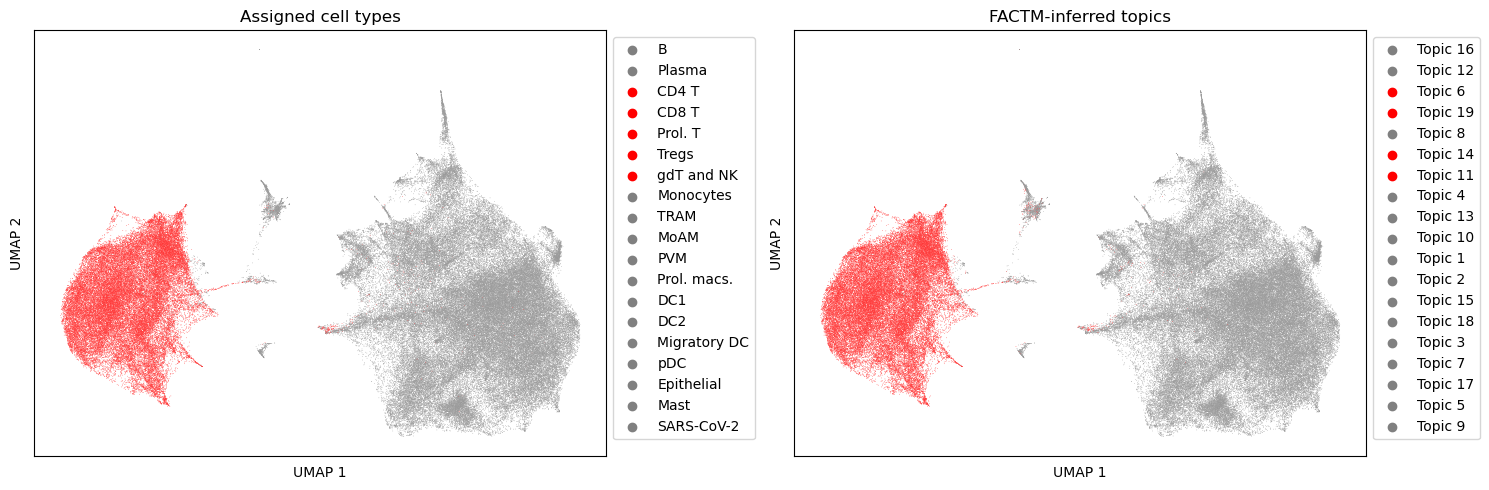

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.scatterplot(x=embedding_umap[:,0], y=embedding_umap[:,1], hue=classes_new_names, ax=axes[0], s=0.2,
                hue_order=class_order_new_names, 
                palette=cell_type_palette_v1)
axes[0].set_title('Assigned cell types')
axes[0].set_xticks([]) 
axes[0].set_yticks([]) 
axes[0].set_xlabel('UMAP 1') 
axes[0].set_ylabel('UMAP 2') 
axes[0].legend(bbox_to_anchor=(1., 1), loc='upper left')

sns.scatterplot(x=embedding_umap[:,0], y=embedding_umap[:,1], hue=clusters,
                     hue_order=clusters_order, palette=topic_palette_grey_v1, s=0.2, ax=axes[1])
axes[1].legend(bbox_to_anchor=(1., 1), loc='upper left')
axes[1].set_xticks([]) 
axes[1].set_yticks([]) 
axes[1].set_xlabel('UMAP 1') 
axes[1].set_ylabel('UMAP 2') 
axes[1].set_title('FACTM-inferred topics')

plt.tight_layout()

# plt.savefig("UMAP_T_cells.png")
plt.show()

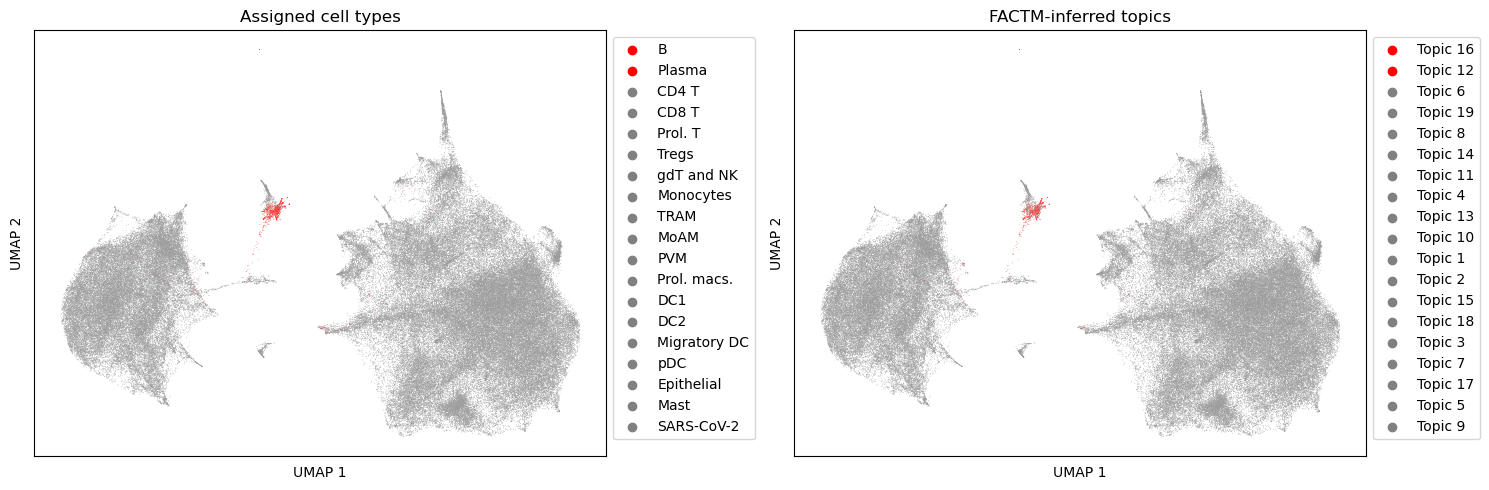

In [ ]:
cell_type_palette_v1 = deepcopy(cell_type_palette_grey_new_names)
cell_type_palette_v1['B'] = dist_color
cell_type_palette_v1['Plasma'] = dist_color

topic_palette_grey_v1 = deepcopy(topic_palette_grey)
topic_palette_grey_v1['Topic 16'] = dist_color
topic_palette_grey_v1['Topic 12'] = dist_color


fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.scatterplot(x=embedding_umap[:,0], y=embedding_umap[:,1], hue=classes_new_names, ax=axes[0], s=0.2,
                hue_order=class_order_new_names, 
                palette=cell_type_palette_v1)
axes[0].set_title('Assigned cell types')
axes[0].set_xticks([]) 
axes[0].set_yticks([]) 
axes[0].set_xlabel('UMAP 1') 
axes[0].set_ylabel('UMAP 2') 
axes[0].legend(bbox_to_anchor=(1., 1), loc='upper left')

sns.scatterplot(x=embedding_umap[:,0], y=embedding_umap[:,1], hue=clusters,
                     hue_order=clusters_order, palette=topic_palette_grey_v1, s=0.2, ax=axes[1])
axes[1].legend(bbox_to_anchor=(1., 1), loc='upper left')
axes[1].set_xticks([]) 
axes[1].set_yticks([]) 
axes[1].set_xlabel('UMAP 1') 
axes[1].set_ylabel('UMAP 2') 
axes[1].set_title('FACTM-inferred topics')

plt.tight_layout()
# plt.savefig("UMAP_B_cells.png")
plt.show()

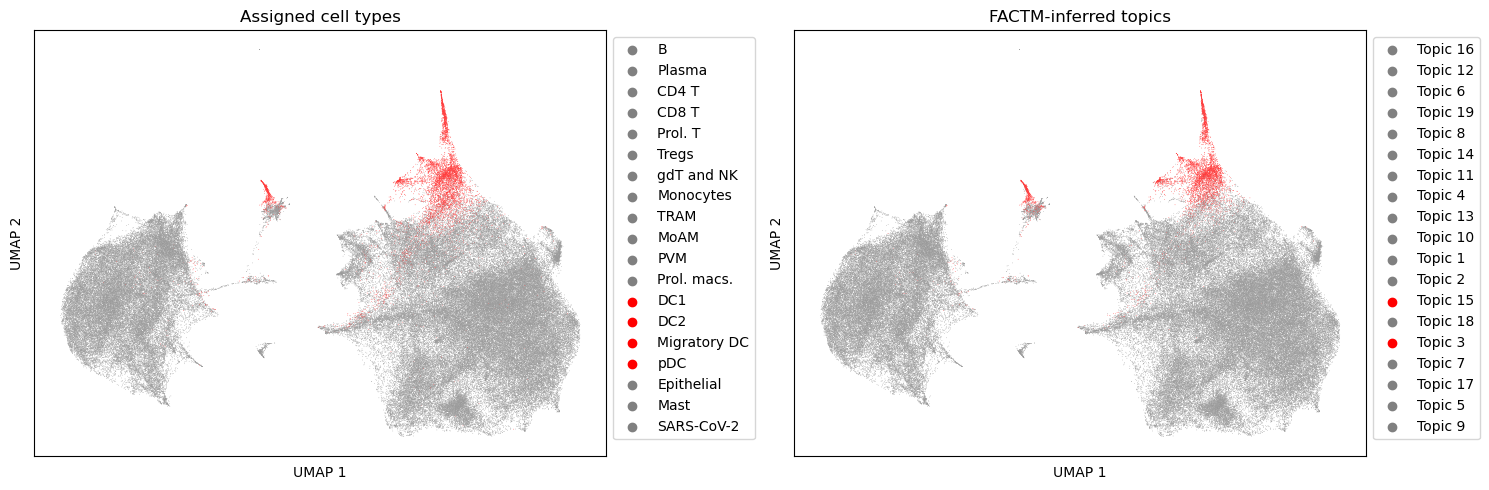

In [ ]:
cell_type_palette_v1 = deepcopy(cell_type_palette_grey_new_names)
cell_type_palette_v1['DC1'] = dist_color
cell_type_palette_v1['DC2'] = dist_color
cell_type_palette_v1['pDC'] = dist_color
cell_type_palette_v1['Migratory DC'] = dist_color

topic_palette_grey_v1 = deepcopy(topic_palette_grey)
topic_palette_grey_v1['Topic 15'] = dist_color
topic_palette_grey_v1['Topic 3'] = dist_color


fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.scatterplot(x=embedding_umap[:,0], y=embedding_umap[:,1], hue=classes_new_names, ax=axes[0], s=0.2,
                hue_order=class_order_new_names, 
                palette=cell_type_palette_v1)
axes[0].set_title('Assigned cell types')
axes[0].set_xticks([]) 
axes[0].set_yticks([]) 
axes[0].set_xlabel('UMAP 1') 
axes[0].set_ylabel('UMAP 2') 
axes[0].legend(bbox_to_anchor=(1., 1), loc='upper left')

sns.scatterplot(x=embedding_umap[:,0], y=embedding_umap[:,1], hue=clusters,
                     hue_order=clusters_order, palette=topic_palette_grey_v1, s=0.2, ax=axes[1])
axes[1].legend(bbox_to_anchor=(1., 1), loc='upper left')
axes[1].set_xticks([]) 
axes[1].set_yticks([]) 
axes[1].set_xlabel('UMAP 1') 
axes[1].set_ylabel('UMAP 2') 
axes[1].set_title('FACTM-inferred topics')

plt.tight_layout()
# plt.savefig("UMAP_DC_cells.png")
plt.show()

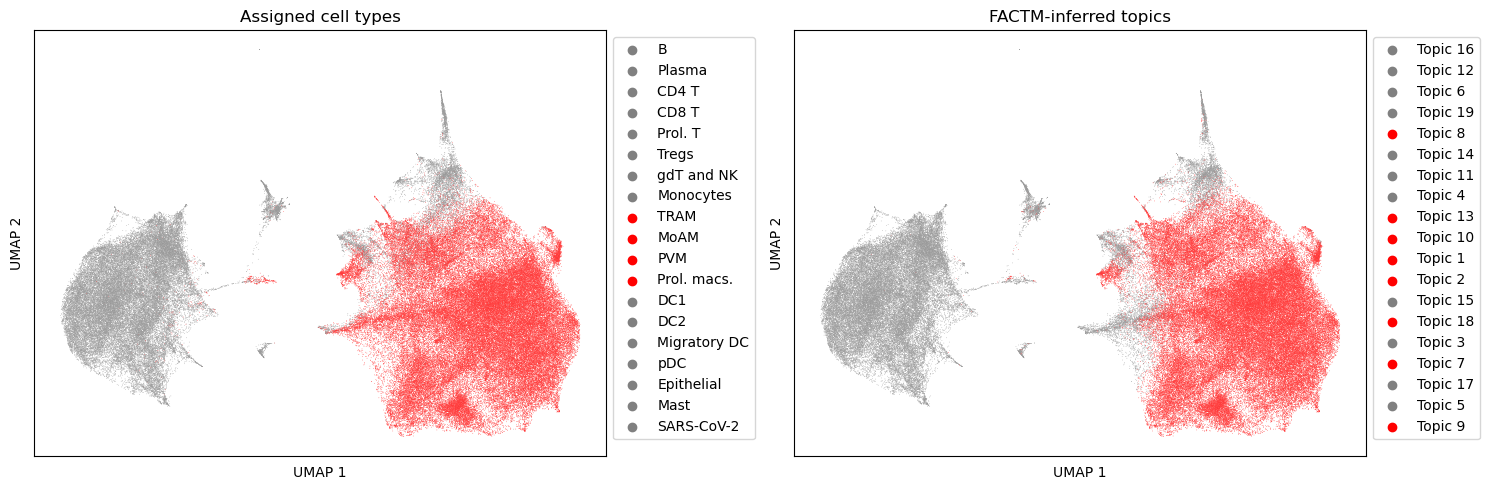

In [ ]:
cell_type_palette_v1 = deepcopy(cell_type_palette_grey_new_names)
cell_type_palette_v1['MoAM'] = dist_color
cell_type_palette_v1['PVM'] = dist_color
cell_type_palette_v1['Prol. macs.'] = dist_color
cell_type_palette_v1['TRAM'] = dist_color

topic_palette_grey_v1 = deepcopy(topic_palette_grey)
topic_palette_grey_v1['Topic 18'] = dist_color
topic_palette_grey_v1['Topic 10'] = dist_color
topic_palette_grey_v1['Topic 1'] = dist_color
topic_palette_grey_v1['Topic 2'] = dist_color
topic_palette_grey_v1['Topic 13'] = dist_color
topic_palette_grey_v1['Topic 9'] = dist_color
topic_palette_grey_v1['Topic 7'] = dist_color
topic_palette_grey_v1['Topic 8'] = dist_color


fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.scatterplot(x=embedding_umap[:,0], y=embedding_umap[:,1], hue=classes_new_names, ax=axes[0], s=0.2,
                hue_order=class_order_new_names, 
                palette=cell_type_palette_v1)
axes[0].set_title('Assigned cell types')
axes[0].set_xticks([]) 
axes[0].set_yticks([]) 
axes[0].set_xlabel('UMAP 1') 
axes[0].set_ylabel('UMAP 2') 
axes[0].legend(bbox_to_anchor=(1., 1), loc='upper left')

sns.scatterplot(x=embedding_umap[:,0], y=embedding_umap[:,1], hue=clusters,
                     hue_order=clusters_order, palette=topic_palette_grey_v1, s=0.2, ax=axes[1])
axes[1].legend(bbox_to_anchor=(1., 1), loc='upper left')
axes[1].set_xticks([]) 
axes[1].set_yticks([]) 
axes[1].set_xlabel('UMAP 1') 
axes[1].set_ylabel('UMAP 2') 
axes[1].set_title('FACTM-inferred topics')

plt.tight_layout()
# plt.savefig("UMAP_Macrophages.png")
plt.show()

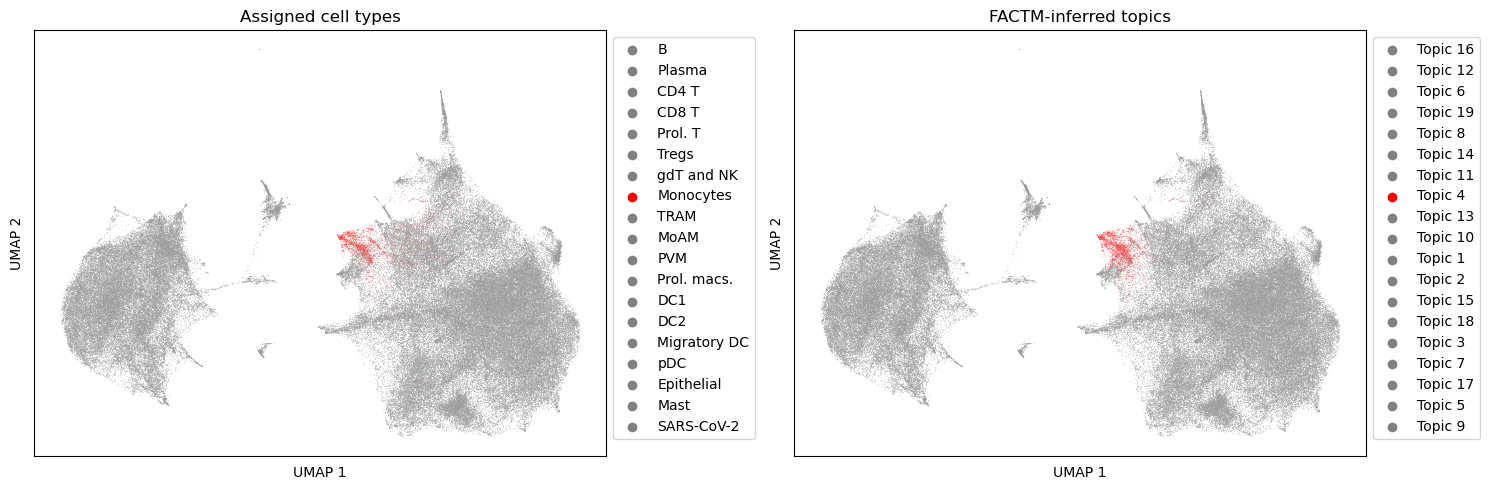

In [ ]:
cell_type_palette_v1 = deepcopy(cell_type_palette_grey_new_names)
cell_type_palette_v1['Monocytes'] = dist_color
topic_palette_grey_v1 = deepcopy(topic_palette_grey)
topic_palette_grey_v1['Topic 4'] = dist_color

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.scatterplot(x=embedding_umap[:,0], y=embedding_umap[:,1], hue=classes_new_names, ax=axes[0], s=0.2,
                hue_order=class_order_new_names, 
                palette=cell_type_palette_v1)
axes[0].set_title('Assigned cell types')
axes[0].set_xticks([]) 
axes[0].set_yticks([]) 
axes[0].set_xlabel('UMAP 1') 
axes[0].set_ylabel('UMAP 2') 
axes[0].legend(bbox_to_anchor=(1., 1), loc='upper left')

sns.scatterplot(x=embedding_umap[:,0], y=embedding_umap[:,1], hue=clusters,
                     hue_order=clusters_order, palette=topic_palette_grey_v1, s=0.2, ax=axes[1])
axes[1].legend(bbox_to_anchor=(1., 1), loc='upper left')
axes[1].set_xticks([]) 
axes[1].set_yticks([]) 
axes[1].set_xlabel('UMAP 1') 
axes[1].set_ylabel('UMAP 2') 
axes[1].set_title('FACTM-inferred topics')

plt.tight_layout()
# plt.savefig("UMAP_Monocytes.png")
plt.show()

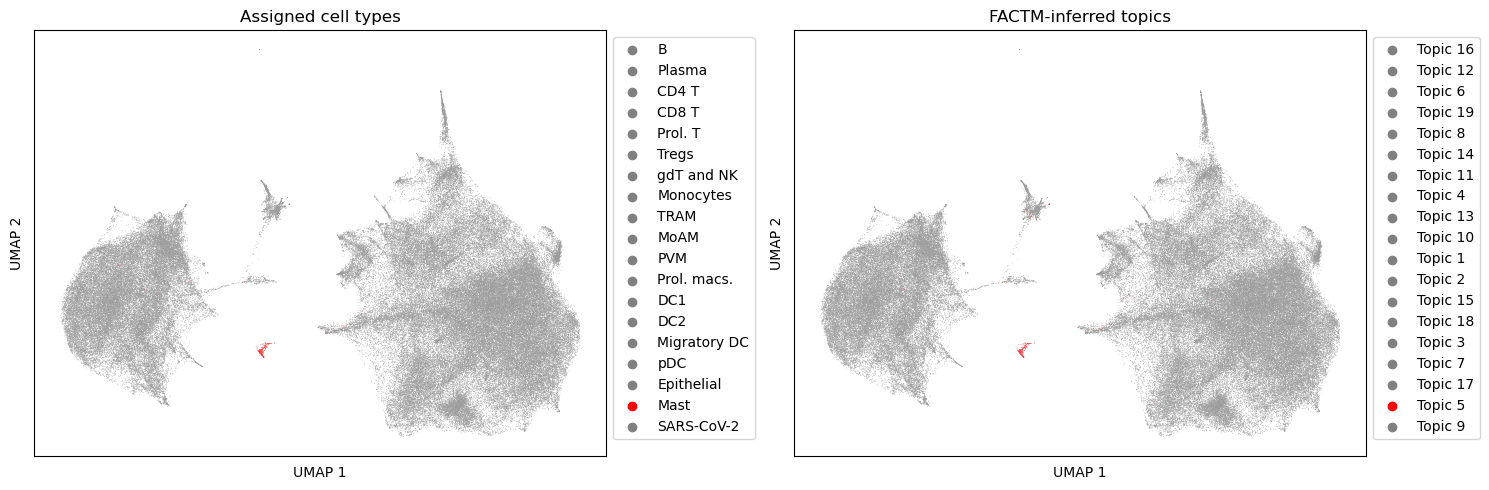

In [ ]:
cell_type_palette_v1 = deepcopy(cell_type_palette_grey_new_names)
cell_type_palette_v1['Mast'] = dist_color
topic_palette_grey_v1 = deepcopy(topic_palette_grey)
topic_palette_grey_v1['Topic 5'] = dist_color

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.scatterplot(x=embedding_umap[:,0], y=embedding_umap[:,1], hue=classes_new_names, ax=axes[0], s=0.2,
                hue_order=class_order_new_names, 
                palette=cell_type_palette_v1)
axes[0].set_title('Assigned cell types')
axes[0].set_xticks([]) 
axes[0].set_yticks([]) 
axes[0].set_xlabel('UMAP 1') 
axes[0].set_ylabel('UMAP 2') 
axes[0].legend(bbox_to_anchor=(1., 1), loc='upper left')

sns.scatterplot(x=embedding_umap[:,0], y=embedding_umap[:,1], hue=clusters,
                     hue_order=clusters_order, palette=topic_palette_grey_v1, s=0.2, ax=axes[1])
axes[1].legend(bbox_to_anchor=(1., 1), loc='upper left')
axes[1].set_xticks([]) 
axes[1].set_yticks([]) 
axes[1].set_xlabel('UMAP 1') 
axes[1].set_ylabel('UMAP 2') 
axes[1].set_title('FACTM-inferred topics')

plt.tight_layout()
# plt.savefig("UMAP_Mast.png")
plt.show()

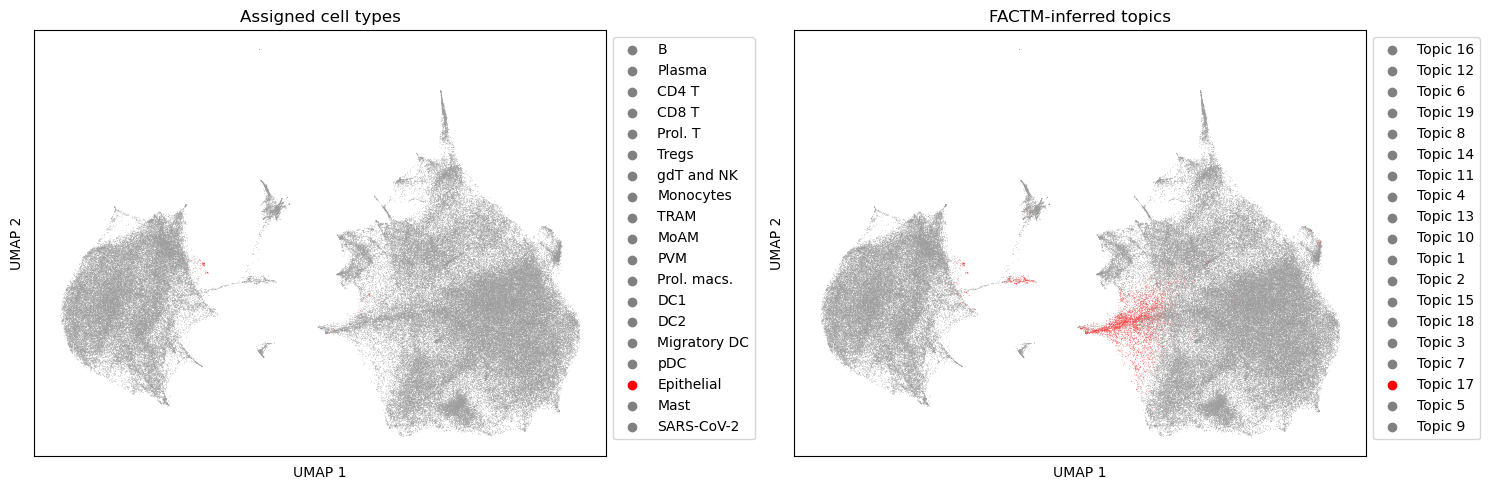

In [ ]:
cell_type_palette_v1 = deepcopy(cell_type_palette_grey_new_names)
cell_type_palette_v1['Epithelial'] = dist_color
topic_palette_grey_v1 = deepcopy(topic_palette_grey)
topic_palette_grey_v1['Topic 17'] = dist_color

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.scatterplot(x=embedding_umap[:,0], y=embedding_umap[:,1], hue=classes_new_names, ax=axes[0], s=0.2,
                hue_order=class_order_new_names, 
                palette=cell_type_palette_v1)
axes[0].set_title('Assigned cell types')
axes[0].set_xticks([]) 
axes[0].set_yticks([]) 
axes[0].set_xlabel('UMAP 1') 
axes[0].set_ylabel('UMAP 2') 
axes[0].legend(bbox_to_anchor=(1., 1), loc='upper left')

sns.scatterplot(x=embedding_umap[:,0], y=embedding_umap[:,1], hue=clusters,
                     hue_order=clusters_order, palette=topic_palette_grey_v1, s=0.2, ax=axes[1])
axes[1].legend(bbox_to_anchor=(1., 1), loc='upper left')
axes[1].set_xticks([]) 
axes[1].set_yticks([]) 
axes[1].set_xlabel('UMAP 1') 
axes[1].set_ylabel('UMAP 2') 
axes[1].set_title('FACTM-inferred topics')

plt.tight_layout()
# plt.savefig("UMAP_Epithelial.png")
plt.show()